LSTM (single input, Sequential API -> Tensorflow)

PREPROCESSING

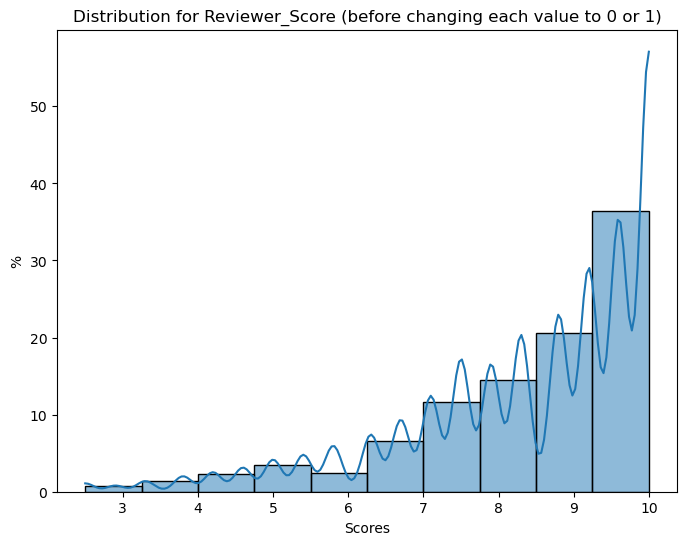

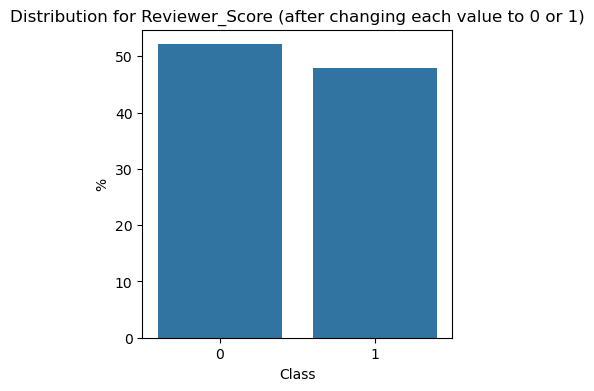

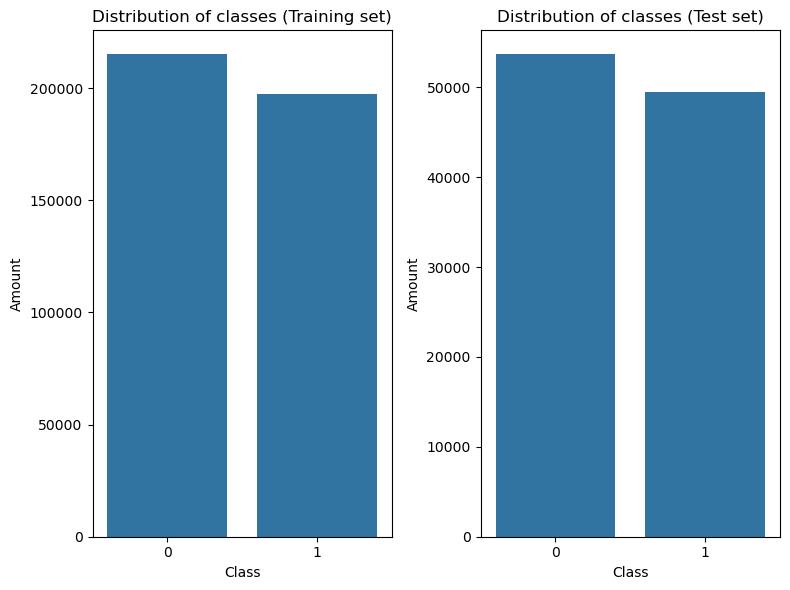

X_train_number_numpy shape: (412590, 7)
X_test_number_numpy shape: (103148, 7)
y_train_target_numpy shape: (412590,)
y_test_target_numpy shape: (103148,)


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import category_encoders as ce
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import seaborn as sns

path = "Hotel_Reviews.csv"
overview_of_features = ["Hotel_Address", "Additional_Number_of_Scoring", "Review_Date",
       "Average_Score", "Hotel_Name", "Reviewer_Nationality",
       "Negative_Review", "Review_Total_Negative_Word_Counts",
       "Total_Number_of_Reviews", "Positive_Review",
       "Review_Total_Positive_Word_Counts",
       "Total_Number_of_Reviews_Reviewer_Has_Given", "Reviewer_Score", "Tags",
       "days_since_review", "lat", "lng"]

# Features
number_columns = ["Additional_Number_of_Scoring",
              "Average_Score", "Review_Total_Negative_Word_Counts",
              "Total_Number_of_Reviews", "Review_Total_Positive_Word_Counts",
              "Total_Number_of_Reviews_Reviewer_Has_Given"]

text_columns = ["Negative_Review", "Positive_Review"]

target_feature = "Reviewer_Score" # to be predicted in the model

# low_memory=False reads the entire file and then decides on what values are in each column, which gives better accuracy
dataset = pd.read_csv(path, usecols=(number_columns + [target_feature, "Reviewer_Nationality"]), low_memory=False)

plt.figure(figsize=(8, 6))
sns.histplot(dataset[target_feature], bins=10, kde=True, stat="percent")
plt.title("Distribution for Reviewer_Score (before changing each value to 0 or 1)")
plt.xlabel("Scores")
plt.ylabel("%")
plt.show()

# Converts the values in target_feature to 0 or 1, values greater than 9 will be 1, and values below 9 will be 0.
# This essentially works as binning for the target_feature (some values are put in 0 and some in 1)
# 9 is chosen here because 10 is a value that holds almost half the dataset, meaning setting it to anything below 9
# would make it an imbalanced dataset (for instance 8, where we then would have to look at using SMOTE, under- and/or oversampling etc.).
# It will now probably be easier to avoid overfitting (because the problem has been reduced to a binary classification problem,
# meaning the model does not need to learn as many parameters as if it was a continous model), and the divide at 9 makes sense in terms
# of what we want to predict
# (e.g is it a low or high score). Since I am making a binary classification model some information will be lost (but choosing the
# right number here is important to minimise information loss, since a wrong number can create an imbalanced dataset, which can
# affect classification and performance). This way we also can avoid using other teqhniques like one-hot encoding (which could be
# demanding and unneccesary), or binning of the contionous values in the target_feature (also information loss here) + ordinal encoder.
dataset[target_feature] = (dataset[target_feature] >= 9).astype("int")

plt.figure(figsize=(4, 4))
sns.countplot(x=dataset[target_feature], stat="percent")
plt.title("Distribution for Reviewer_Score (after changing each value to 0 or 1)")
plt.xlabel("Class")
plt.ylabel("%")
plt.show()

for column in number_columns:
    dataset[column] = pd.to_numeric(dataset[column], errors="coerce") # converts any string value to numeric value + error returns NaN

X = dataset.drop(columns=[target_feature])
y = dataset[target_feature] # target column/feature
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

# Target Encoding (column has many unique values, converts the values of 'Reviewer_Nationality' into numerical
# values. This is done by replacing each value with the mean of "Reviewer_Score" for that value,
# see variable y from the split which has the target variable)
target_encoder = ce.TargetEncoder(cols=["Reviewer_Nationality"])
X_train["Reviewer_Nationality"] = target_encoder.fit_transform(X_train["Reviewer_Nationality"], y_train)
X_test["Reviewer_Nationality"] = target_encoder.transform(X_test["Reviewer_Nationality"], y_test)

# Standardize features to mean=0 and std=1 for better model performance
scaler = StandardScaler()
X_train[number_columns + ["Reviewer_Nationality"]] = scaler.fit_transform(X_train[number_columns + ["Reviewer_Nationality"]])
X_test[number_columns + ["Reviewer_Nationality"]] = scaler.transform(X_test[number_columns + ["Reviewer_Nationality"]])

# Convert data to NumPy arrays (float32 = numbers)
X_train_number_numpy = X_train[number_columns + ["Reviewer_Nationality"]].to_numpy(dtype="float32")
X_test_number_numpy = X_test[number_columns + ["Reviewer_Nationality"]].to_numpy(dtype="float32")

y_train_target_numpy = y_train.to_numpy(dtype="int32")
y_test_target_numpy = y_test.to_numpy(dtype="int32")

# Two plots (to show distribution)
plt.figure(figsize=(8, 6))

plt.subplot(1, 2, 1)
sns.countplot(x=y_train_target_numpy)
plt.title("Distribution of classes (Training set)")
plt.xlabel("Class")
plt.ylabel("Amount")

plt.subplot(1, 2, 2)
sns.countplot(x=y_test_target_numpy)
plt.title("Distribution of classes (Test set)")
plt.xlabel("Class")
plt.ylabel("Amount")

plt.tight_layout()
plt.show()

print("X_train_number_numpy shape:", X_train_number_numpy.shape)
print("X_test_number_numpy shape:", X_test_number_numpy.shape)
print("y_train_target_numpy shape:", y_train_target_numpy.shape)
print("y_test_target_numpy shape:", y_test_target_numpy.shape)

THE MODEL

The text columns have been dropped, as The Sequantial API only allows one input and the numerical inputs give the information we want.

Epoch 1/10
10315/10315 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - accuracy: 0.7327 - loss: 0.5322 - val_accuracy: 0.7434 - val_loss: 0.5202
Epoch 2/10
10315/10315 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - accuracy: 0.7433 - loss: 0.5207 - val_accuracy: 0.7433 - val_loss: 0.5192
Epoch 3/10
10315/10315 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - accuracy: 0.7434 - loss: 0.5186 - val_accuracy: 0.7448 - val_loss: 0.5209
Epoch 4/10
10315/10315 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - accuracy: 0.7430 - loss: 0.5182 - val_accuracy: 0.7446 - val_loss: 0.5197
Epoch 5/10
10315/10315 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - accuracy: 0.7430 - loss: 0.5180 - val_accuracy: 0.7447 - val_loss: 0.5173
Epoch 6/10
10315/10315 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - accuracy: 0.7436 - loss: 0.5180 - val_accuracy: 0.7448 - val_loss: 0.5172
Epoch 7/10
10315/10315 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - accuracy: 0.7457 - loss: 0.5159 - val_accuracy: 0.7451 - val_loss: 0.5166
Epoch 8/10
10315/10315 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - accuracy: 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 84)          │        30,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 84)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 1, 84)          │        56,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 84)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 1, 84)          │        56,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 84)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 84)             │        56,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 84)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 20)             │         1,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 608,957 (2.32 MB)

 Trainable params: 202,985 (792.91 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 405,972 (1.55 MB)

None


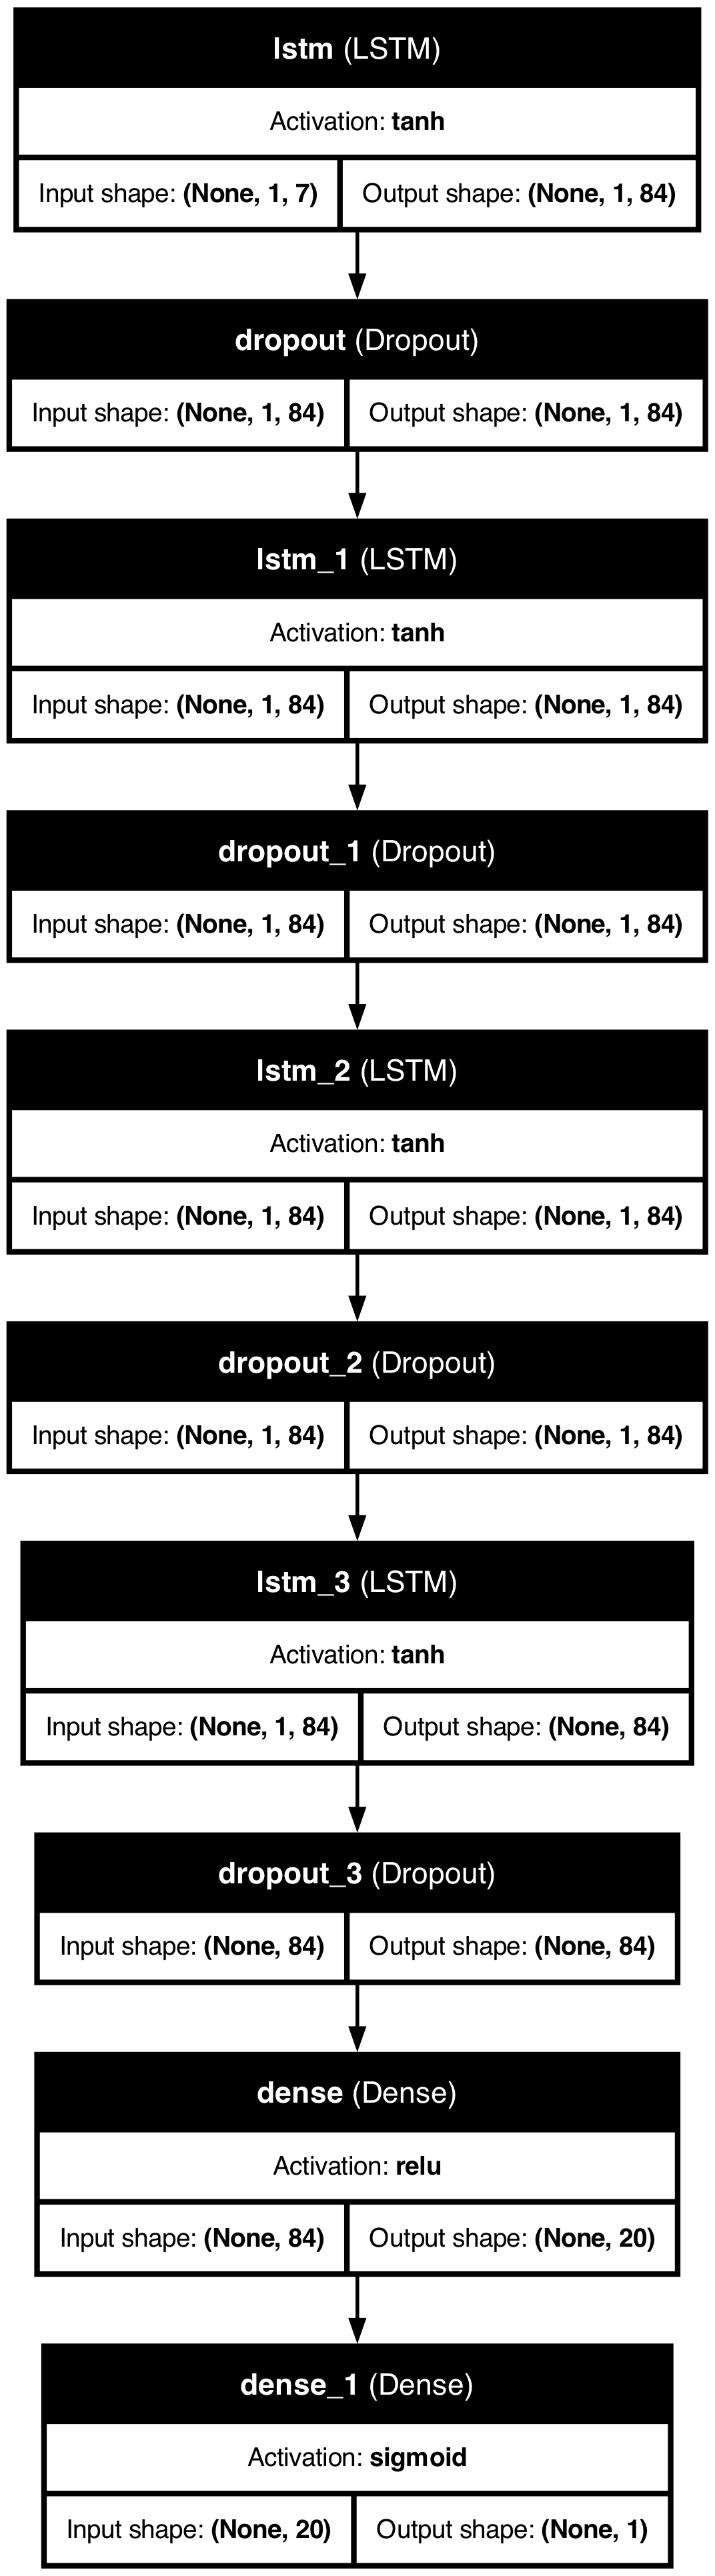

In [ ]:
# THE SEQUENTIAL MODEL: https://www.tensorflow.org/guide/keras/sequential_model

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.utils import plot_model

# Reshape the data, so that it can be used with the model
# That means the model has the required 3D shape: [batch_size, time steps, features]
# shape[0] = batch_size (number of samples)
# tall = timesteps (iterations per sample)
# .shape[1] = features (number of columns/features for each iteration)
X_train_lstm = X_train_number_numpy.reshape(X_train_number_numpy.shape[0], 1, X_train_number_numpy.shape[1])
X_test_lstm = X_test_number_numpy.reshape(X_test_number_numpy.shape[0], 1, X_test_number_numpy.shape[1])

# LSTM instance
lstm = Sequential()

# Input layer (first layer - 84 neurons), input_shape is (timesteps, features)
# timesteps = iterations per sample (set to 1), features = number of columns, which is 7
# return_sequences=True sends the full output to the next layer (for each input)
lstm.add(Input(shape=(1, 7)))
lstm.add(LSTM(units=84, return_sequences=True))
lstm.add(Dropout(0.2)) # droput regularisation (used to prevent overfitting, standard)

# Hidden layer (nr. 2)
lstm.add(LSTM(units=84, return_sequences=True))
lstm.add(Dropout(0.2))

# Hidden layer (nr. 3)
lstm.add(LSTM(units=84, return_sequences=True))
lstm.add(Dropout(0.2))

# Hidden layer (nr. 4)
lstm.add(LSTM(units=84, return_sequences=False))
lstm.add(Dropout(0.2))

# Hidden layer (nr. 5), fully connected (e.g Dense(), with ReLu activation function
lstm.add(Dense(units=20, activation="relu"))

# Output layer (linear activation function for output)
lstm.add(Dense(units=1, activation="sigmoid"))

# Compile the model
lstm.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model
lstm.fit(
    X_train_lstm,
    y_train_target_numpy,
    batch_size=40,
    epochs=10,
    validation_data=(X_test_lstm, y_test_target_numpy)
)

# Predictions (between 0 and 1)
prediction_1 = lstm.predict(X_train_lstm)
prediction_2 = lstm.predict(X_test_lstm)

# Classification: Class 1 if prediction is > 0.5, class 0 if prediction is <= 0.5
classification_1 = [1 if probability > 0.5 else 0 for probability in prediction_1]
classification_2 = [1 if probability > 0.5 else 0 for probability in prediction_2]

print(lstm.summary())
plot_model(lstm,
           show_shapes=True,
           show_layer_names=True,
           show_layer_activations=True,
           expand_nested=True)

EVALUATION OF THE MODEL

Accuracy: classification_1 predicts y_train_target_numpy: 0.7452216486100003
Accuracy: classification_2 predicts y_test_target_numpy: 0.7437759336099585
Difference in accuracy: 0.0014457150000417585 



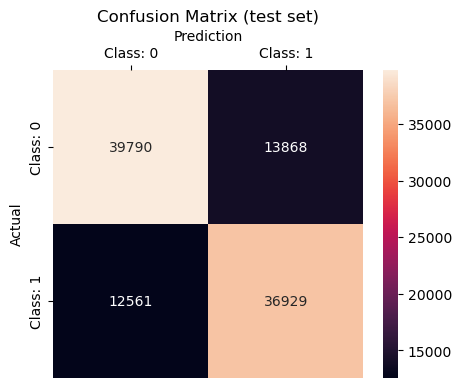

Classification report (test set):
               precision    recall  f1-score   support

    Class: 0       0.76      0.74      0.75     53658
    Class: 1       0.73      0.75      0.74     49490

    accuracy                           0.74    103148
   macro avg       0.74      0.74      0.74    103148
weighted avg       0.74      0.74      0.74    103148

AUC Score (Test Set): 0.8215484890984768


In [3]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Accuracy (training and test set)
accuracy_train = accuracy_score(y_train_target_numpy, classification_1)
accuracy_test = accuracy_score(y_test_target_numpy, classification_2)
print(f"Accuracy: classification_1 predicts y_train_target_numpy: {accuracy_train}")
print(f"Accuracy: classification_2 predicts y_test_target_numpy: {accuracy_test}")
print("Difference in accuracy:", accuracy_train - accuracy_test, "\n")

# Confusion Matrix (test set)
matrix = confusion_matrix(y_test_target_numpy, classification_2)
plt.figure(figsize=(5, 4))
var = sns.heatmap(matrix, annot=True, fmt="d", xticklabels=["Class: 0", "Class: 1"], yticklabels=["Class: 0", "Class: 1"])
var.xaxis.set_label_position("top")
plt.gca().xaxis.tick_top()
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.title("Confusion Matrix (test set)")
plt.show()

# Classification Report (test set)
print("Classification report (test set):\n", classification_report(y_test_target_numpy, classification_2, target_names=["Class: 0", "Class: 1"]))

# ROC-AUC (test set)
print("AUC Score (Test Set):", roc_auc_score(y_test_target_numpy, prediction_2))